In [2]:
import pickle
import pandas as pd
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

import time
import numpy as np
#from fairlearn.datasets import fetch_acs_income
import shap

from scipy.spatial.distance import cosine, euclidean
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report,  roc_auc_score
from scipy.stats import mannwhitneyu

import tensorflow
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from xgboost import XGBRegressor, XGBClassifier #continuous values?
from scipy.stats import mannwhitneyu


from scipy import stats
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import ttest_ind
import joblib

ImportError: Numba could not be imported.
--------------------------------------------------------------------------------
If you are seeing this message and are undertaking Numba development work, you may need to rebuild Numba.
Please see the development set up guide:

https://numba.readthedocs.io/en/stable/developer/contributing.html.

--------------------------------------------------------------------------------
If you are not working on Numba development, the original error was: 'cannot import name '_typeconv' from 'numba.core.typeconv' (c:\Users\odiee\anaconda3\envs\hcml\Lib\site-packages\numba\core\typeconv\__init__.py)'.
For help, please visit:

https://numba.readthedocs.io/en/stable/user/faq.html#numba-could-not-be-imported


### Load sample

In [2]:
sample = pd.read_csv("sample_data.csv")

In [3]:
numeric_cols = ['WKHP']
categorical_cols = ['AGEP','DIS', 'NATIVITY','NAICSP','SCHL', 'MAR', 'ENG', 'SEX',  'RAC1P']

In [4]:
insurance_data = sample.copy() # create new df for insurance predictions
income_data = sample.copy()

insurance_data.rename(columns={"HICOV": "target"}, inplace=True)
income_data.drop('HICOV', axis = 1, inplace=True)
income_data.rename(columns={"PINCP": "target"}, inplace=True)

In [5]:
def preprocess_income_data(df, threshold):
    df_copy = df.copy()
    df_copy['binary_target'] = (df_copy['target'] >= threshold).astype(int)
    y = df_copy['binary_target']
    X = df_copy.drop(columns=['target', 'binary_target'], errors='ignore')

    return X, y


preprocessor1 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ],
    remainder='passthrough' 
)

threshold = 50000
X, y = preprocess_income_data(income_data, threshold)

# tempsplit: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# final split: validation (15%) and test (15%) from temp
X_val, X_test, y_val, y_test_income = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

preprocessor1.fit(X_train)

X_train_income = preprocessor1.transform(X_train)
X_val_income   = preprocessor1.transform(X_val)
X_test_income  = preprocessor1.transform(X_test)
y_train_income = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_val_income = y_val.to_numpy() if hasattr(y_val, "to_numpy") else y_val



In [6]:
def preprocess_healthcare_data(df):
    df_copy = df.copy()
    
    # Convert target values: 1 → 1 (with insurance), 2 → 0 (no insurance)
    df_copy['binary_target'] = (df_copy['target'] == 1).astype(int)

    # Separate features and target
    X = df_copy.drop(columns=['target', 'binary_target'], errors='ignore')
    y = df_copy['binary_target']
    
    return X, y

# Define the column transformer
preprocessor2 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ],
    remainder='passthrough'
)

# Run preprocessing
X, y = preprocess_healthcare_data(insurance_data)

# Split: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split: validation (15%) and test (15%)
X_val, X_test, y_val, y_test_health = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Fit and transform
preprocessor2.fit(X_train)

X_train_health = preprocessor2.transform(X_train)
X_val_health   = preprocessor2.transform(X_val)
X_test_health  = preprocessor2.transform(X_test)

y_train_health = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_val_health = y_val.to_numpy() if hasattr(y_val, "to_numpy") else y_val

In [7]:
income_feature_names = preprocessor1.named_transformers_['cat'].get_feature_names_out(categorical_cols)
health_feature_names = preprocessor2.named_transformers_['cat'].get_feature_names_out(categorical_cols)
numeric_cols_health =  ['AGEP', 'WKHP', 'PINCP']
all_feature_names_income = list(income_feature_names) + numeric_cols
all_feature_names_health = list(health_feature_names) + numeric_cols_health

In [ ]:
# Get the SHAP-values

shap_values_tp_health = np.load("treeshap_values_health.npy")
shap_values_tp_income = np.load("treeshap_values_income.npy")
shap_values_dp_health = np.load("deepshap_values_health.npy")
shap_values_dp_income = np.load("deepshap_values_income.npy")

## Statistical tests

In [22]:
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    
    # calculate the pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    
    # return NaN if pooled_std is zero or NaN
    if pooled_std == 0 or np.isnan(pooled_std):
        return np.nan
    
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    
    # calculate the effect size
    return (u1 - u2) / pooled_std


In [62]:
COW = {1:"Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
2:"Employee of a private not-for-profit, tax-exempt, or charitable organization",
3:"Local government employee (city, county, etc.)",
4:"State government employee",
5:"Federal government employee",
6:"Self-employed in own not incorporated business, professional practice, or farm",
7:"Self-employed in own incorporated business, professional practice or farm",
8:"Working without pay in family business or farm",
9:"Unemployed and last worked 5 years ago or earlier or never worked"}
SCHL = {1:"No schooling completed",
2:"Nursery school or preschool",
3:"Kindergarten",
4:"Grade 1",
5:"Grade 2",
6:"Grade 3",
7:"Grade 4",
8:"Grade 5",
9:"Grade 6",
10:"Grade 7",
11:"Grade 8",
12:"Grade 9",
13:"Grade 10",
14:"Grade 11",
15:"Grade 12 (no diploma)",
16:"Regular high school diploma",
17:"GED or alternative credential",
18:"Some college but less than 1 year",
19:"1 or more years of college credit but no degree",
20:"Associate’s degree",
21:"Bachelor’s degree",
22:"Master’s degree",
23:"Professional degree beyond a bachelor’s degree",
24:"Doctorate degree"}
MAR = {1:"Married", 2:"Widowed", 3:"Divorced",4:"Separated",5:"Never married or under 15 years old"}
RELP = {0:"Reference person",
1:"Husband or wife",
2:"Biological son or daughter",
3:"Adopted son or daughter",
4:"Stepson or stepdaughter",
5:"Brother or sister",
6:"Father or mother",
7:"Grandchild",
8:"Parent-in-law",
9:"Son-in-law or daughter-in-law",
10:"Other relative",
11:"Roomer or boarder",
12:"Housemate or roommate",
13:"Unmarried partner",
14:"Foster child",
15:"Other nonrelative",
16:"Institutionalized group quarters population. Includes correctional facilities, nursing homes, and mental hospitals.",
17:"Noninstitutionalized group quarters population. Includes college dormitories, military barracks, group homes, missions, and shelters."}
SEX = {1:"Male", 2:"Female"}
RAC1P = {1:"White alone",
2:"Black or African American alone",
3:"American Indian alone",
4:"Alaska Native alone",
5:"American Indian and Alaska native tribes specified; or American Indian or Alaska Native, not specified and no other races",
6:"Asian alone",
7:"Native Hawaiian and Other Pacific Islander alone",
8:"Some Other Race alone",
9:"Two or More races"}
AGEP = {
    '15_25': 'Age 15–25',
    '25_45': 'Age 25–45',
    '45_60': 'Age 45–60',
    '60_plus': 'Age 60+'
}
DIS = {1: "With disability", 2: "Without disability"}

### TreeSHAP

In [ ]:
## Function to generate subgroups by taking all combinations of two features (e.g. sex and race)
def extract_subgroups(df, attr1, attr2):
    attr_values = {
        'SEX': [1, 2],
        'RAC1P': [1, 2, 6, 8, 9], # to-do: limit number of races
        'MAR': [0,1],  # to-do: binarise
        'AGEP': ['15_25', '25_45', '45_60', '60+'],
        'DIS': [1,2]
    }
    subgroups = {}

    for val1 in attr_values[attr1]:
        for val2 in attr_values[attr2]:
            subgroup_name = f"{attr1}_{val1}_{attr2}_{val2}"
            mask = (df[attr1] == val1) & (df[attr2] == val2)
            subgroups[subgroup_name] = mask.values 

    return subgroups

# e.g. 
# subgroups = extract_subgroups(X_test_filtered, 'SEX', 'RAC1P')

def t_test_all_subgroups(df, shap_values, attr1, attr2):

    subgroup_masks = extract_subgroups(df, attr1, attr2)
    t_test_results = []

    feature_names = ['COW_1.0', 'COW_2.0', 'COW_3.0', 'COW_4.0', 'COW_5.0', 'COW_6.0', 'COW_7.0', 'COW_8.0','DIS_1', 'DIS_2',
                 'SCHL_1.0', 'SCHL_2.0', 'SCHL_3.0', 'SCHL_4.0', 'SCHL_5.0', 'SCHL_6.0', 'SCHL_7.0', 'SCHL_8.0', 'SCHL_9.0', 'SCHL_10.0', 'SCHL_11.0', 'SCHL_12.0', 'SCHL_13.0', 'SCHL_14.0', 'SCHL_15.0', 'SCHL_16.0', 'SCHL_17.0', 'SCHL_18.0', 'SCHL_19.0', 'SCHL_20.0', 'SCHL_21.0', 'SCHL_22.0', 'SCHL_23.0', 'SCHL_24.0',
                 'MAR_0.0', 'MAR_1.0',  
                 'RELP_0.0', 'RELP_1.0', 'RELP_2.0', 'RELP_3.0', 'RELP_4.0', 'RELP_5.0', 'RELP_6.0', 'RELP_7.0', 'RELP_8.0', 'RELP_9.0', 'RELP_10.0', 'RELP_11.0', 'RELP_12.0', 'RELP_13.0', 'RELP_14.0', 'RELP_15.0', 'RELP_16.0', 'RELP_17.0',
                 'SEX_1.0', 'SEX_2.0',
                 'RAC1P_1.0', 'RAC1P_2.0', 'RAC1P_6.0', 'RAC1P_8.0', 'RAC1P_9.0',
                 'AGEP_15_25', 'AGEP_25_45', 'AGEP_45_60', 'AGEP_15_25', 'AGEP_60_plus',
                 'WKHP']

    for (name1, mask1), (name2, mask2) in itertools.combinations(subgroup_masks.items(), 2):
        shap1 = shap_values[mask1]
        shap2 = shap_values[mask2]

        # skip if there are no instances belonging to the subgroup
        if shap1.shape[0] == 0 or shap2.shape[0] == 0:
            continue

        for i, feature in enumerate(feature_names):
            group1 = shap1[:, i]
            group2 = shap2[:, i]
            
            group1 = preprocessing.normalize(group1.reshape(1, -1), norm='l2').flatten()
            group2 = preprocessing.normalize(group2.reshape(1, -1), norm='l2').flatten()
    
            #stat, pval = ttest_ind(group1, group2, equal_var=False) # Welch's t-test to account for variance differences
            stat_u, p_value_u = mannwhitneyu(group1, group2)
            effect_size = cohend(group1, group2)
            mean_diff = group1.mean() - group2.mean()
 
            full_feature = feature
            
            try:
                parts = feature.split('_')
                if parts[0] == 'AGEP':
                    category_name = '_'.join(parts[1:])
                    full_feature = AGEP.get(category_name, feature)
 
                else:
                    target = parts[0]
                    index = int(float(parts[1]))
 
                    full_feature = (
                        COW[index] if target == 'COW' else
                        SCHL[index] if target == 'SCHL' else
                        MAR[index] if target == 'MAR' else
                        RELP[index] if target == 'RELP' else
                        SEX[index] if target == 'SEX' else
                        RAC1P[index] if target == 'RAC1P' else
                        feature
                    )
            except:
                if feature == 'WKHP':
                    full_feature = "working hours per week"

            t_test_results.append({
                'subgroup1': name1,
                'subgroup2': name2,
                'feature': feature,
                'feature description': full_feature,
                't_stat': stat_u,
                'p_value': p_value_u,
                'effect_size': effect_size,
                'mean_diff': mean_diff
            })
            
    return pd.DataFrame(t_test_results)

In [ ]:
attr_combinations = [
    ('RAC1P', 'SEX'),
    ('AGEP', 'SEX'),
    ('MAR', 'SEX'),
    ('DIS', 'SEX'),
    ('DIS', 'RAC1P')
]

shap_sets = {
    'health': shap_values_tp_health,
    'income': shap_values_tp_income
}

for shap_label, shap_values in shap_sets.items():
    print(f"\n\n================== SHAP Target: {shap_label.upper()} ==================")
    
    for attr1, attr2 in attr_combinations:
        print(f"\n---- Analyzing Subgroups: {attr1} x {attr2} ----")

        try:
            df_result = t_test_all_subgroups(X_test, shap_values, attr1=attr1, attr2=attr2)
            df_result['attr1'] = attr1
            df_result['attr2'] = attr2
            df_result['target'] = shap_label

            # Filter for effect size
            significant_results = df_result[df_result['effect_size'].abs() > 0.5]
            significant_results = significant_results.sort_values(by='effect_size', ascending=False)

            if significant_results.empty:
                print("No significant results (|Cohen's d| > 0.5)")
            else:
                print(significant_results[['feature description', 'subgroup1', 'subgroup2', 'effect_size', 'p_value']].head(25))

        except KeyError as e:
            print(f"Skipped due to missing column: {e}")
        except Exception as e:
            print(f"Error processing {attr1} x {attr2}: {e}")




================== SHAP Target: HEALTH ==================

---- Analyzing Subgroups: RAC1P x SEX ----
No significant results (|Cohen's d| > 0.2)

---- Analyzing Subgroups: AGEP x SEX ----
No significant results (|Cohen's d| > 0.2)

---- Analyzing Subgroups: MAR x SEX ----
No significant results (|Cohen's d| > 0.2)

---- Analyzing Subgroups: DIS x SEX ----
No significant results (|Cohen's d| > 0.2)

---- Analyzing Subgroups: DIS x RAC1P ----
                                    feature description      subgroup1  \
1371                                    Master’s degree  DIS_1_RAC1P_6   
1533                              Some Other Race alone  DIS_1_RAC1P_6   
1505                                    Master’s degree  DIS_1_RAC1P_6   
1528                                               Male  DIS_1_RAC1P_6   
1296                                           Grade 11  DIS_1_RAC1P_6   
1861  Institutionalized group quarters population. I...  DIS_1_RAC1P_8   
90                                 

c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


                  feature description      subgroup1      subgroup2  \
2704            Grade 12 (no diploma)  RAC1P_8_SEX_1  RAC1P_9_SEX_1   
1498            Grade 12 (no diploma)  RAC1P_2_SEX_1  RAC1P_9_SEX_1   
1230            Grade 12 (no diploma)  RAC1P_2_SEX_1  RAC1P_6_SEX_1   
1665  Black or African American alone  RAC1P_2_SEX_2  RAC1P_6_SEX_1   
1799  Black or African American alone  RAC1P_2_SEX_2  RAC1P_8_SEX_1   
2302            Grade 12 (no diploma)  RAC1P_6_SEX_1  RAC1P_9_SEX_2   
2972            Grade 12 (no diploma)  RAC1P_9_SEX_1  RAC1P_9_SEX_2   
2101            Grade 12 (no diploma)  RAC1P_6_SEX_1  RAC1P_8_SEX_1   
2134  Black or African American alone  RAC1P_6_SEX_1  RAC1P_8_SEX_1   

      effect_size        p_value  
2704     1.604103  5.940533e-315  
1498     1.434191   0.000000e+00  
1230     1.329853   0.000000e+00  
1665     1.300149   0.000000e+00  
1799    -0.685202   9.437976e-93  
2302    -1.329201   0.000000e+00  
2972    -1.433358   0.000000e+00  
2101    -

c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


KeyboardInterrupt: 

In [54]:
results_df = t_test_all_subgroups(X_test, shap_values, attr1='RAC1P', attr2='SEX').sort_values('effect_size', ascending=False)
significant_results = results_df[results_df['effect_size'].abs() > 0.2] # filter for (abs) cohen d value over 0.1

c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [55]:
print(significant_results)

          subgroup1      subgroup2    feature            feature description  \
2584  RAC1P_8_SEX_1  RAC1P_9_SEX_1  SCHL_17.0  GED or alternative credential   
1432  RAC1P_2_SEX_1  RAC1P_9_SEX_1  SCHL_17.0  GED or alternative credential   
1176  RAC1P_2_SEX_1  RAC1P_6_SEX_1  SCHL_17.0  GED or alternative credential   
1593  RAC1P_2_SEX_2  RAC1P_6_SEX_1  RAC1P_8.0          Some Other Race alone   
1721  RAC1P_2_SEX_2  RAC1P_8_SEX_1  RAC1P_8.0          Some Other Race alone   
2200  RAC1P_6_SEX_1  RAC1P_9_SEX_2  SCHL_17.0  GED or alternative credential   
2840  RAC1P_9_SEX_1  RAC1P_9_SEX_2  SCHL_17.0  GED or alternative credential   
2008  RAC1P_6_SEX_1  RAC1P_8_SEX_1  SCHL_17.0  GED or alternative credential   
2041  RAC1P_6_SEX_1  RAC1P_8_SEX_1  RAC1P_8.0          Some Other Race alone   

         t_stat        p_value  effect_size     mean_diff  
2584  45.574115  5.940533e-315     1.604103  3.637979e-12  
1432  55.605755   0.000000e+00     1.434191  3.637979e-12  
1176  55.605755   0

### DeepSHAP

### Misc

In [ ]:
mask_A = (X_test['SEX'] == 1) & (X_test['RAC1P'] == 1)
mask_B = (X_test['SEX'] == 2) & (X_test['RAC1P'] == 1)

shap_male = shap_values[mask_A.values]
shap_female = shap_values[mask_B.values]
feature_names = ['COW_1.0', 'COW_2.0', 'COW_3.0', 'COW_4.0', 'COW_5.0', 'COW_6.0', 'COW_7.0', 'COW_8.0', 'SCHL_1.0', 'SCHL_2.0', 'SCHL_3.0', 'SCHL_4.0', 'SCHL_5.0', 'SCHL_6.0', 'SCHL_7.0', 'SCHL_8.0', 'SCHL_9.0', 'SCHL_10.0', 'SCHL_11.0', 'SCHL_12.0', 'SCHL_13.0', 'SCHL_14.0', 'SCHL_15.0', 'SCHL_16.0', 'SCHL_17.0', 'SCHL_18.0', 'SCHL_19.0', 'SCHL_20.0', 'SCHL_21.0', 'SCHL_22.0', 'SCHL_23.0', 'SCHL_24.0', 'MAR_1.0', 'MAR_2.0', 'MAR_3.0', 'MAR_4.0', 'MAR_5.0', 'RELP_0.0', 'RELP_1.0', 'RELP_2.0', 'RELP_3.0', 'RELP_4.0', 'RELP_5.0', 'RELP_6.0', 'RELP_7.0', 'RELP_8.0', 'RELP_9.0', 'RELP_10.0', 'RELP_11.0', 'RELP_12.0', 'RELP_13.0', 'RELP_14.0', 'RELP_15.0', 'RELP_16.0', 'RELP_17.0', 'SEX_1.0', 'SEX_2.0', 'RAC1P_1.0', 'RAC1P_2.0', 'RAC1P_3.0', 'RAC1P_4.0', 'RAC1P_5.0', 'RAC1P_6.0', 'RAC1P_7.0', 'RAC1P_8.0', 'RAC1P_9.0', 'AGEP', 'WKHP']

 
shapiro_list = []
shapiro_listW = []
levenes = []
z_list = []
t_test = []
u_test = []
cohendlist = []
statsreport = []

print(len(feature_names))
 
normality_warnings = 0
varience_warnings = 0
 
for i, feature in enumerate(feature_names):
    group1 = shap_male[:, i]
    group2 = shap_female[:, i]
    
    # randomly sample 5000 instances of both groups
    try:
        group1 = np.random.choice(group1, size=4000, replace=False)
        group2 = np.random.choice(group2, size=4000, replace=False)
    except:
        pass # array is already less than 5000
 
    # normalise- L2:
    group1 = preprocessing.normalize(group1.reshape(1, -1), norm='l2').flatten()
    group2 = preprocessing.normalize(group2.reshape(1, -1), norm='l2').flatten()
    
    # Shapiro-Wilk test
    shapiro_gr1 = shapiro(group1).pvalue
    shapiro_gr2 = shapiro(group2).pvalue
    shapiroW_gr1 = shapiro(group1).statistic
    shapiroW_gr2 = shapiro(group2).statistic
    shapiro_list.append([shapiro_gr1, shapiro_gr2])
    shapiro_listW.append([shapiroW_gr1, shapiroW_gr2])
 
    # Levenes test ---> depends on assumption of normality!
    w_stats, p_value = levene(group1, group2, center='mean')
    levenes.append([w_stats, p_value])
 
    # outlier test ---> depends on assumption of normality!
    z1 = np.abs(stats.zscore(group1))
    z2 = np.abs(stats.zscore(group2))
    z_list.append([z1, z2])
 
    stat, pval = ttest_ind(group1, group2)  # Welch's t-test to account for variance differences
    t_test.append([stat,pval])
    stat_u, p_value_u = mannwhitneyu(group1, group2)
    u_test.append([stat_u,p_value_u])
 
    cohens_d = cohend(group1, group2),
    cohendlist.append(cohens_d)


    statsreport.append({
        'Shapiro p value group 1,2': [shapiro_gr1, shapiro_gr2],
        'Shapiro statistic group 1,2': [shapiroW_gr1, shapiroW_gr2],
        'Levenes p-value':p_value,
        'Levenes statistic':w_stats ,
        't-test p-value': stat,
        't-test statistic': pval,
        'u-test p-value': p_value_u,
        'u_test statistic': stat_u,
        'effect size': cohens_d,
        'mean_diff': group1.mean() - group2.mean()
        
    })
t_test_df = pd.DataFrame(statsreport)
t_test_df = t_test_df.sort_values('effect size')
print(t_test_df.head(15))


#print("Shapiro values: ", shapiro_list)
#print("Shapiro statistic: ", shapiro_listW)
#print("Levens values: ", levenes)

68


c:\Users\Collin\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Collin\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:3345: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
C:\Users\Collin\AppData\Local\Temp\ipykernel_34080\4079862287.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return (u1 - u2) / s
c:\Users\Collin\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Collin\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:3345: RuntimeWarning: invalid value encountered in scalar divide
  W = n

                           Shapiro p value group 1,2  \
53   [2.401897640619104e-43, 2.0057580910702215e-89]   
60      [3.428652288328508e-89, 2.1670135584154e-89]   
51  [1.0524912055159761e-89, 1.5212582664385487e-89]   
23  [5.0213354194912205e-88, 1.8672877276396206e-88]   
39   [8.523580945737969e-89, 1.6740675833319277e-88]   
37    [1.005679849375963e-27, 7.313699604554771e-29]   
57   [1.1541691897367889e-89, 1.836884232953645e-89]   
47   [1.497675399635916e-88, 2.5822645723121526e-88]   
24   [1.4889441831903227e-87, 8.745418130509383e-88]   
55    [4.905041694136631e-89, 6.442895378587504e-89]   
9   [3.2233904364136743e-77, 3.3843703768949527e-78]   
11    [3.461945965735273e-89, 3.251085726168567e-89]   
10    [9.617661661520791e-82, 4.681270765899626e-80]   
4     [3.035211812325992e-42, 3.135214879208831e-41]   
41    [3.579999765506906e-89, 3.901184312987872e-89]   

                     Shapiro statistic group 1,2  Levenes p-value  \
53    [0.9115965688123647, 0.02224

c:\Users\Collin\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Collin\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:3345: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
C:\Users\Collin\AppData\Local\Temp\ipykernel_34080\4079862287.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return (u1 - u2) / s
c:\Users\Collin\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Collin\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:3345: RuntimeWarning: invalid value encountered in scalar divide
  W = n

In [43]:
print("z-scores that deviate: ", z_list)
#print("t-test  values: ",t_test)
#print("u-test  values: ",u_test)

z-scores that deviate:  [[array([0.38747337, 0.34099305, 0.42442775, ..., 0.34429225, 0.36295924,
       0.35591105], dtype=float32), array([0.43186784, 0.37920555, 0.4508314 , ..., 0.40733585, 0.36218005,
       0.37735018], dtype=float32)], [array([0.31695408, 0.7925253 , 0.76969683, ..., 1.1741679 , 0.96208847,
       0.43777466], dtype=float32), array([1.0991379 , 0.71492565, 1.0446622 , ..., 0.88902915, 1.423526  ,
       0.63610417], dtype=float32)], [array([ 2.356973  ,  0.31614655,  0.2551176 , ...,  0.2465995 ,
       12.352101  ,  0.1768775 ], dtype=float32), array([0.11368082, 0.32580137, 0.0872758 , ..., 0.04877985, 0.7734856 ,
       0.45326543], dtype=float32)], [array([1.9275223 , 0.23180784, 0.14970748, ..., 0.25593615, 0.35793096,
       0.4797636 ], dtype=float32), array([0.45066252, 0.37561205, 1.4511414 , ..., 3.22885   , 0.10038998,
       0.19166797], dtype=float32)], [array([0.3322054 , 0.41834444, 1.0348971 , ..., 0.15850791, 0.50343746,
       0.21117248], dtyp

Statistical to-do:
1) L2 - normalize all SHAP vectors to be used
2) Apply Shapiro-Wilk test on a sample of N = 5000 to check for normality
3) Independent t-test / non-parametric test regardless of small p-values
4) effect size (threshold of D <= 0.2)
 

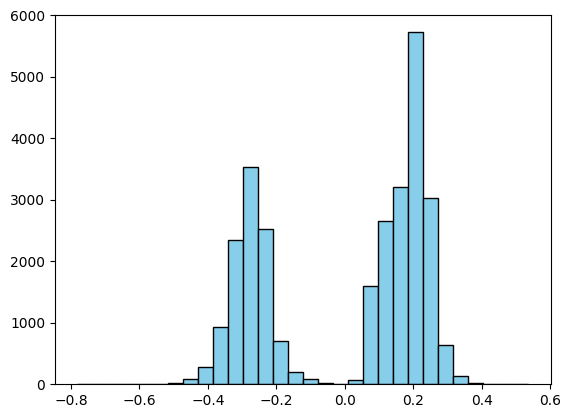

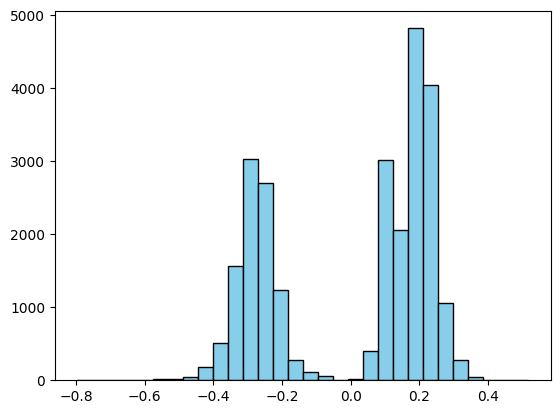

In [44]:
import matplotlib.pyplot as plt
import numpy as np

for i, feature in enumerate(feature_names):
    group1 = shap_male[:, i+1]
    group2 = shap_female[:, i+1]

    plt.hist(group1, bins=30, color='skyblue', edgecolor='black')

    plt.show()
    plt.hist(group2, bins=30, color='skyblue', edgecolor='black')

    plt.show()
    break